In [3]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params
from multi_group_simulation import MultiGroupSimulation

In [4]:
grp_params, grp_names, interactions_mtx = \
    load_multigroup_params("../src/simulations_v2/params/multigroup/uw_groups.yaml")
    # load_multigroup_params("../src/simulations_v2/params/multigroup/dorms_vs_no_dorms.yaml")

/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:65: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:132: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/load_params.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [5]:
multigrp_sim = MultiGroupSimulation(grp_params, interactions_mtx, grp_names)

In [11]:
num_trajectories = 100
sim_dfs_group_0 = []
sim_dfs_group_1 = []
sim_dfs_group_2 = []
for _ in range(num_trajectories):
    multigrp_sim.reset_initial_state()
    for _ in range(112):
        multigrp_sim.step()
    sim_dfs_group_0.append(multigrp_sim.sims[0].sim_df)
    sim_dfs_group_1.append(multigrp_sim.sims[1].sim_df)
    sim_dfs_group_2.append(multigrp_sim.sims[2].sim_df)

Text(0, 0.5, 'Dorm Community')

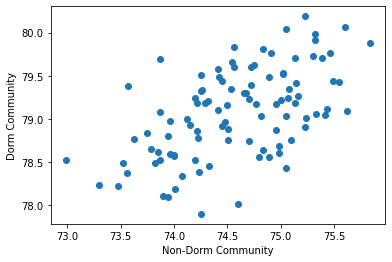

In [12]:
def get_popsize(df):
    cols = df.columns
    subdf = df[[col for col in cols if 'cumulative' not in col]]
    return subdf.sum(axis=1).iloc[0]

def infection_pct(df):
    popsize = get_popsize(df)
    
    subdf = df[['cumulative_mild', 'cumulative_severe']]
    infections = subdf.sum(axis=1).iloc[-1]
    
    return infections / popsize * 100

pct_0s = []
pct_1s = []
for df_grp_0, df_grp_1 in zip(sim_dfs_group_0, sim_dfs_group_1):
    pct_0, pct_1 = infection_pct(df_grp_0), infection_pct(df_grp_1)
    pct_0s.append(pct_0)
    pct_1s.append(pct_1)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pct_0s, pct_1s)
plt.xlabel("Non-Dorm Community")
plt.ylabel("Dorm Community")
    

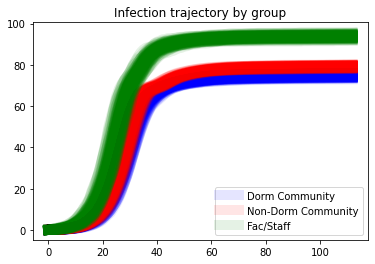

In [13]:
def add_df_plot(df, label, color):
    popsize = get_popsize(df)
    df[['S', 'QS']].apply(lambda x: (popsize - sum(x)) / popsize * 100, axis=1) \
                        .plot(label=label, alpha=0.1, linewidth=10, color=color)
    
#sim_dfs_group_0 = []
#sim_dfs_group_1 = []

add_df_plot(sim_dfs_group_0[0], label="Dorm Community", color='blue')
for df0 in sim_dfs_group_0[1:]:
    add_df_plot(df0, label='', color='blue')

add_df_plot(sim_dfs_group_1[0], label="Non-Dorm Community", color='red')
for df1 in sim_dfs_group_1[1:]:
    add_df_plot(df1, label='', color='red')
    
add_df_plot(sim_dfs_group_2[0], label="Fac/Staff", color='green')
for df1 in sim_dfs_group_2[1:]:
    add_df_plot(df1, label='', color='green')

plt.title("Infection trajectory by group")
plt.legend(loc='best')

# Simulate over many parameters

In [27]:
import copy
orig_grp_params = copy.deepcopy(grp_params)
print(grp_params[1]['expected_contacts_per_day'])
print(interactions_mtx[1,0])

20
1.0


In [28]:

def run_sims(grp_params, interactions_mtx, grp_names, num_trajectories):
    multigrp_sim = MultiGroupSimulation(grp_params, interactions_mtx, grp_names)
    sim_dfs_group_0 = []
    sim_dfs_group_1 = []
    for _ in range(num_trajectories):
        multigrp_sim.reset_initial_state()
        for _ in range(112):
            multigrp_sim.step()
        sim_dfs_group_0.append(multigrp_sim.sims[0].sim_df)
        sim_dfs_group_1.append(multigrp_sim.sims[1].sim_df)
    return sim_dfs_group_0, sim_dfs_group_1

In [30]:
dorm_contacts = [20, 40, 60, 80]
inter_group_contact_rates = [1]

grp0_results = {}
grp1_results = {}

for rate in inter_group_contact_rates:
    for contacts in dorm_contacts:
        grp_params[1]['expected_contacts_per_day'] = contacts
        interactions_mtx[1,0] = rate
        interactions_mtx[0,1] = rate
        
        grp0_results[(contacts, rate)], grp1_results[(contacts, rate)] = \
            run_sims(grp_params, interactions_mtx, grp_names, num_trajectories=25)
        print("Done simulating {}".format((contacts, rate)))
        

Done simulating (20, 1)
Done simulating (40, 1)
Done simulating (60, 1)
Done simulating (80, 1)


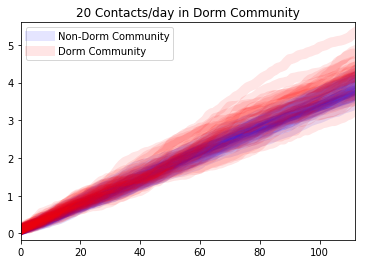

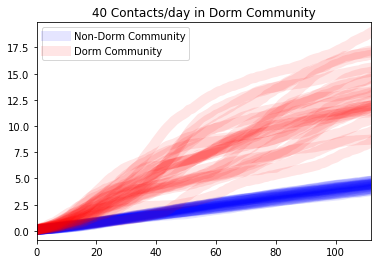

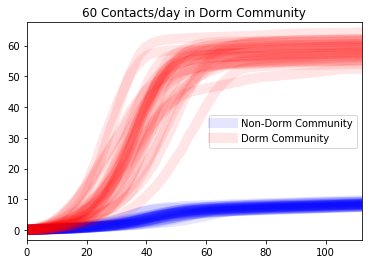

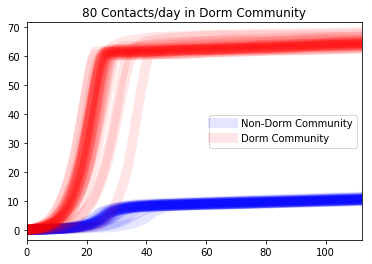

In [33]:
def plot_df_pairs(dfs0, label0, dfs1, label1, title):
    add_df_plot(dfs0[0], label=label0, color='blue')
    for df0 in dfs0[1:]:
        add_df_plot(df0, label='', color='blue')

    add_df_plot(dfs1[0], label=label1, color='red')
    for df1 in dfs1[1:]:
        add_df_plot(df1, label='', color='red')


    plt.title(title)
    plt.legend(loc='best')
    plt.show()

for contacts in dorm_contacts:
    plot_df_pairs(grp0_results[(contacts, 1)], "Non-Dorm Community", 
                  grp1_results[(contacts,1)], "Dorm Community", 
                  title="{} Contacts/day in Dorm Community".format(contacts))

In [34]:
dorm_contacts = [20, 40, 60, 80]
inter_group_contact_rates = [3]

grp0_results = {}
grp1_results = {}

for rate in inter_group_contact_rates:
    for contacts in dorm_contacts:
        grp_params[1]['expected_contacts_per_day'] = contacts
        interactions_mtx[1,0] = rate
        interactions_mtx[0,1] = rate
        
        grp0_results[(contacts, rate)], grp1_results[(contacts, rate)] = \
            run_sims(grp_params, interactions_mtx, grp_names, num_trajectories=25)
        print("Done simulating {}".format((contacts, rate)))
        

Done simulating (20, 3)
Done simulating (40, 3)
Done simulating (60, 3)
Done simulating (80, 3)


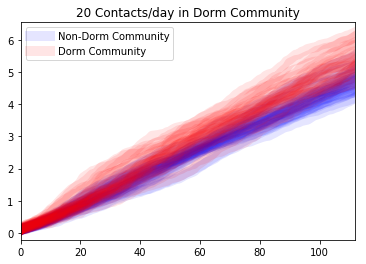

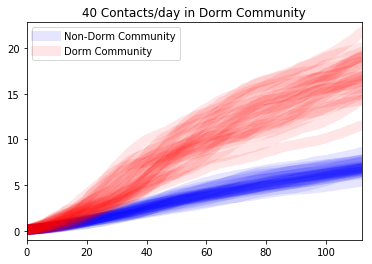

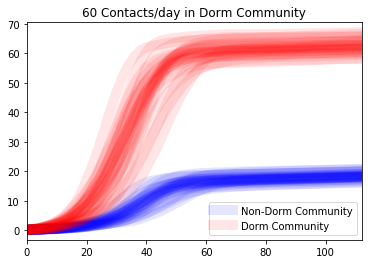

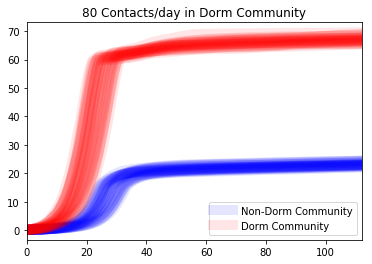

In [35]:
for contacts in dorm_contacts:
    plot_df_pairs(grp0_results[(contacts, 3)], "Non-Dorm Community", 
                  grp1_results[(contacts,3)], "Dorm Community", 
                  title="{} Contacts/day in Dorm Community".format(contacts))